In [1]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation

import optitrack.csv_reader as csv
from optitrack.geometry import *

filename = "../material/60fps/ProvaRigidBody.csv"

### READ CSV AND LOAD DATA

In [2]:
# Read the file.
take = csv.Take().readCSV(filename)

# Print out some statistics
print("Found rigid bodies:", take.rigid_bodies.keys())

# Process the first rigid body into a set of planes.
bodies = take.rigid_bodies

bones_pos = []
if len(bodies) > 0:
    for body in bodies: 
        bones = take.rigid_bodies[body]
        bones_pos.append(bones.positions)

# substitute with [0,0,0] 'None' values
matrix = [[0,0,0] if elem is None else elem for elem in bones_pos[0]]

# Extract x, y, z coordinates from the data
x = [point[0] for point in matrix]
y = [point[1] for point in matrix]
z = [point[2] for point in matrix]
positions = np.array([x, y, z]).T


Found rigid bodies: dict_keys(['Ragnetto'])


### DISPLACE ANIMATION

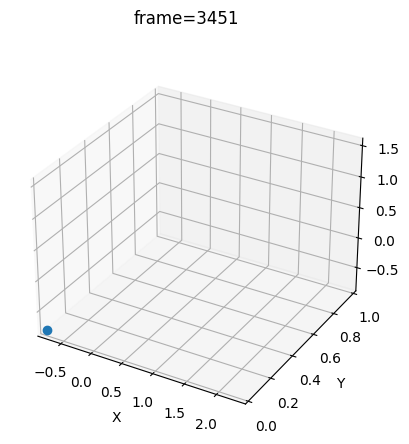

In [3]:

n_frames = len(positions)

# Plot properties
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel('Z')

ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))

txt = fig.suptitle('')

# initialize empty set of points
points, = ax.plot([], [], [], "o")

# define an animation function
# this determines the plot's behavior at each frame
def update(t, x, y, z, points):
    txt.set_text('frame={:d}'.format(t))
    
    # update properties
    updated_positions = np.array(([x[t]], [y[t]], [z[t]]), dtype=float)
    points.set_data_3d(updated_positions)

    # return modified artists
    return points, txt

ani=animation.FuncAnimation(fig, update, frames=n_frames, fargs=(x, y, z, points))
ani.save(filename="/animations/animation.gif", writer="pillow", fps=60)

plt.show()